# Pricing and Hedging - Exercise Two

## start coding

importing modules, and some basic stuff

In [ ]:
# always yielding a real result, even dividing two integers
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

# plot inline
%matplotlib inline

function for a monte carlo path sample, based on *Generalized geometric Brownian* motion:

$$S(t) = S(0)\exp\left \{\sigma W(t) + (r - \frac{1}{2}\sigma^2)t\right \}$$

In [2]:
def mcpath(nsteps, S0, r, vol, T):
    
    # generate nsteps random numbers
    sample=pd.Series(np.random.standard_normal(nsteps))
    
    # define time increment
    dt=T/nsteps
    
    # initialize vectors
    initial = np.zeros(1)
    ts=np.repeat(dt,nsteps)
    
    # calculate s1 and s2
    s1=(r-(vol**2)/2)*dt
    s2=vol*np.sqrt(dt)
    steps=s1*np.repeat(1,nsteps)+s2*sample
    path=steps.cumsum()
    Sj=S0*np.exp(path)
    
    # add initial time t=0
    S = np.concatenate(([S0],Sj))
    t = np.concatenate(([0],ts.cumsum()))
    
    return pd.Series(S,index=t)

An auxiliary function to generate npaths

In [3]:
def mcpaths(npaths, nsteps, S0, r, vol, t):
    # generate npaths using mcpath
    paths=[mcpath(nsteps, S0, r, vol, t) for j in range(npaths)]
    return paths

Let´s test

In [4]:
npaths=10
nsteps=100
S0=100
r=0.1
vol=0.2
T=1
test_mcpaths=mcpaths(npaths,nsteps,S0,r,vol,T)

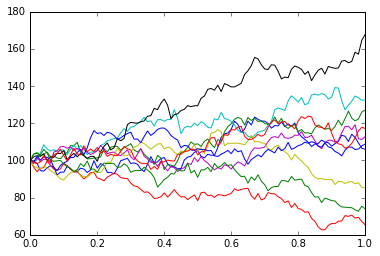

In [5]:
[test_mcpaths[i].plot() for i in range(npaths)]

Defining the Black formula, according to:

$$C(S_0,t) = e^{-rT} \left[FN(d_1) - KN(d_2)\right]$$

Where:

$$F = S_0e^{\left(r-q\right)t}$$

$$d_1 = \frac{1}{\sigma\sqrt{t}} \left[ \ln{\left( \frac{S_0}{K} \right) } + \left( r -q + \frac{\sigma^2}{2} \right) \left(t \right) \right]$$

$$d_2 = d_1 - \sigma\sqrt{t}$$

In [6]:
def bsv(phi,S,K,r,q,vol,t):
    # calculate F
    F=S*np.exp((r-q)*t)
    
    # calculate d1 and d2
    sigma_rt = vol*np.sqrt(t)
    d1=(np.log(S/K)+(r-q+vol**2/2)*t)/(sigma_rt)
    d2=d1-sigma_rt
    
    # calculate N(d1) and N(d2)
    Nd1=st.norm.cdf(phi*d1)
    Nd2=st.norm.cdf(phi*d2)
    
    # calculate delta and premium
    delta=phi*np.exp(-q*t)*Nd1
    premium=S*delta-phi*K*np.exp(-r*t)*Nd2
    
    return [premium,delta]

Testing the function we can verify that results match with this [Black-Scholes Calculator](http://www.math.drexel.edu/~pg/fin/VanillaCalculator.html) from Drexel University
![title](images/bs_calculator.png)

In [7]:
call = 1
put = -1
S0=100
r=0.1
q=.02
vol=0.2
T=1
K=100
[bsv(call,S0,K,r,q,vol,T),bsv(put,S0,K,r,q,vol,T)]

[[11.866121135383175, 0.67777058718221128],
 [4.3299956083035909, -0.30242808612454397]]


Function for calculating portfolio P&L and cash flow value given a path

In [8]:
def calcportfolio(path,phi,K,r,q,vol,T):
    nstp=len(path)-1

    # calculate t,S(t),premium(t),delta(t) using Black Scholes function
    bsvpath=[[path.index[i],path.values[i]]+bsv(call,path.values[i],100,.1,0,.2,1-path.index[i])\
            for i in range(len(path))]
    df = pd.DataFrame(bsvpath,columns=['time','spot','premium','delta'])
       
    # generate cfwprem column to include cash flows regarding premium
    df['cfwprem']=0
    
    # the first cash flow is the price payed to enter the option
    df.loc[0,'cfwprem']=-df['premium'][0]
    
    # at the maturity:
    # - all premium, if any, becomes cash flow regarding option settlement
    # - there is no delta as option expires and we should withdraw the position on asset
    df.loc[nstp,'cfwprem']=df['premium'][nstp]
    df.loc[nstp,'premium']=0
    df.loc[nstp,'delta']=0
       
    # calculate time intervals dt
    df['timechg']=df['time'].diff()
    df.loc[0,'timechg']=0
    
    # calculate changes in delta
    df['dltchg']=df['delta'].diff()
    df.loc[0,'dltchg']=0
    
    # calculate changes in spot price
    df['spotchg']=df['spot'].diff()
    df.loc[0,'spotchg']=0

    # cashflows for heding the portfolio buying/selling delta quantities of the asset
    df['cfwspot']=0
    df.loc[0,'cfwspot']=df['delta'][0]*df['spot'][0]
    df.loc[1:,'cfwspot']=df['dltchg'][1:]*df['spot'][1:]

    # dividend cashflows
    df['cfwdivid']=0
    df.loc[1:,'cfwdivid']=-((df['delta'][0:nstp]*df['spot'][0:nstp]).values)*(np.exp(q*df['timechg'][1:].values)-1)

    # cashflows before interest
    df['cfwprer']=df['cfwprem']+df['cfwspot']+df['cfwdivid']

    # interest and consolidation of cashflows
    df['balance']=0
    df.loc[0,'balance']=df['cfwprer'][0]
    for j in range(1,nstp+1):
        df.loc[j,'balance']=df['balance'][j-1]*(np.exp(r*df['timechg'][j]))+df['cfwprer'][j]

    # portfolio
    df['portf']=df['premium']-df['delta']*df['spot']+df['balance']

    # consolidated discount factor
    return df

some function test, just to see the data frame´s face

In [16]:
call = 1
put = -1
nsteps = 10
S0=100
r=0.1
q=.02
vol=0.2
T=1
K=100
mypath = mcpath(nsteps,S0,r,vol,T)
calcportfolio(mypath,call,K,r,q,vol,T)

,time,spot,premium,delta,cfwprem,timechg,dltchg,spotchg,cfwspot,cfwdivid,cfwprer,balance,portf
0,0.0,100.000000,13.269677,0.725747,-13.269677,0.0,0.000000,0.000000,72.574688,0.000000,59.305012,59.305012,0.000000
1,0.1,107.325673,18.004818,0.826857,0.000000,0.1,0.101111,7.325673,10.851764,-0.145295,10.706469,70.607506,-0.130713
2,0.2,104.985361,15.103616,0.790634,0.000000,0.1,-0.036224,-2.340312,-3.802961,-0.177664,-3.980625,67.336498,-0.564856
3,0.3,100.413624,10.664856,0.700786,0.000000,0.1,-0.089847,-4.571737,-9.021892,-0.166176,-9.188068,58.825173,-0.878480
4,0.4,101.819130,10.621592,0.719423,0.000000,0.1,0.018636,1.405506,1.897515,-0.140878,1.756637,61.173013,-1.456379
5,0.5,107.725334,14.092039,0.829059,0.000000,0.1,0.109637,5.906204,11.810659,-0.146649,11.664010,73.451822,-1.766838
6,0.6,126.815420,30.805708,0.988014,0.000000,0.1,0.158954,19.090086,20.157864,-0.178800,19.979064,94.169089,-0.320580
7,0.7,135.609615,38.569012,0.999062,0.000000,0.1,0.011049,8.794196,1.498310,-0.250842,1.247468,96.362973,-0.550488
8,0.8,138.218267,40.198547,0.999949,0.000000,0.1,0.000887,2.608651,0.122574,-0.271236,-0.148662,97.182774,-0.829931
9,0.9,119.764860,20.762417,0.998823,0.000000,0.1,-0.001126,-18.453407,-0.134896,-0.276699,-0.411595,97.747882,-1.113587


generating a histogram of portfolio P&L

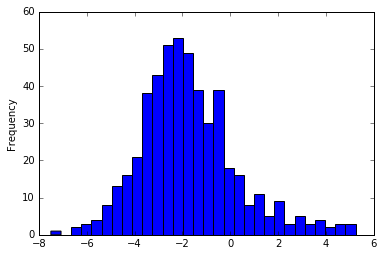

In [17]:
npaths=500
pls = pd.Series([calcportfolio(mcpath(nsteps, S0, r, vol, T),call,K,r,q,vol,T)['portf'][nsteps] for i in range(npaths)])
pls.plot(kind='hist',bins=30)